In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
! pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 13.6 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import re
import emoji
import spacy
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")


In [4]:
# Function to clean text using spaCy
def clean_text_spacy(text):
    if pd.isna(text):  # Check for NaN values
        return ""  # Return an empty string for missing values

    text = str(text)  # Convert non-string values to string
    text = emoji.demojize(text)  # Convert emojis to text
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters & numbers
    text = text.lower().strip()  # Convert to lowercase and remove extra spaces
    doc = nlp(text)  # Process text with spaCy
    tokens = [token.lemma_ for token in doc if not token.is_stop]  # Lemmatization & Stopword removal
    return ' '.join(tokens)


In [5]:
# Load Dataset Safely
file_path = "/content/drive/MyDrive/Python/sandhiya/Text_emoji_label/data.new.xlsx"  # Update with your actual file path

try:
    # Determine file format and load accordingly
    if file_path.endswith(".xlsx") or file_path.endswith(".xls"):
        df = pd.read_excel(file_path)
    elif file_path.endswith(".csv"):
        df = pd.read_csv(file_path, delimiter=",", on_bad_lines="skip", encoding="utf-8")
    else:
        raise ValueError("Unsupported file format! Please provide a CSV or Excel file.")
except Exception as e:
    raise ValueError(f"Error loading dataset: {str(e)}")


In [6]:
# Ensure Required Columns Exist
if "text" not in df.columns or "label" not in df.columns:
    raise ValueError("Dataset must contain 'text' and 'label' columns!")

# Handle Missing or Non-Numeric Labels
df = df.dropna(subset=["label"])  # Remove NaN labels

# Convert Text Labels to Integers
label_mapping = {"ham": 0, "spam": 1}  # Define mapping
df["label"] = df["label"].astype(str).str.lower().map(label_mapping)

# Remove any rows where label conversion failed (i.e., unknown labels)
df = df.dropna(subset=["label"])
df["label"] = df["label"].astype(int)  # Ensure labels are integers


In [7]:
# Apply Text Cleaning
df["text"] = df["text"].fillna("")  # Replace NaN values with empty strings
df["clean_text"] = df["text"].apply(clean_text_spacy)

# Drop Empty Cleaned Text Rows
df = df[df["clean_text"].str.strip() != ""]

# Check for Empty DataFrame
if df.empty:
    raise ValueError("No valid samples found after text cleaning. Please check your dataset.")


<ipython-input-8-6561c01e3768>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["label"], palette=["blue", "red"])


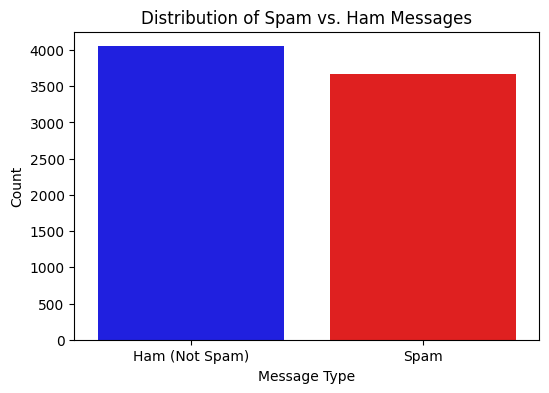

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the number of spam and ham messages
plt.figure(figsize=(6, 4))
sns.countplot(x=df["label"], palette=["blue", "red"])
plt.xticks(ticks=[0, 1], labels=["Ham (Not Spam)", "Spam"])
plt.xlabel("Message Type")
plt.ylabel("Count")
plt.title("Distribution of Spam vs. Ham Messages")
plt.show()


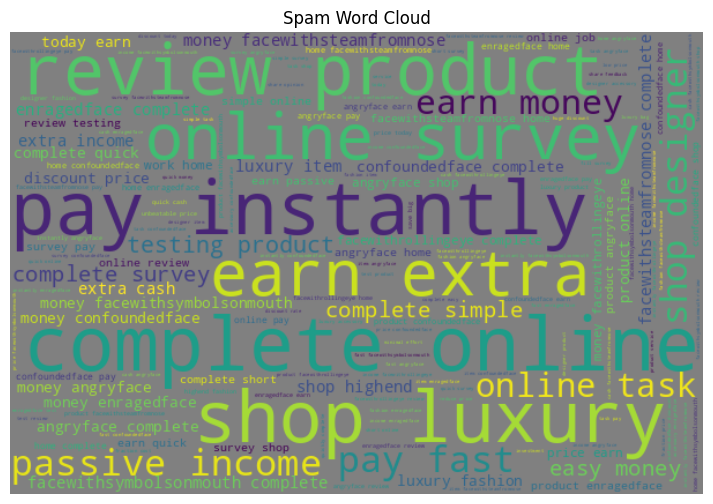

In [9]:
from wordcloud import WordCloud

# Generate word cloud for spam messages
spam_words = " ".join(df[df["label"] == 1]["clean_text"])
spam_wordcloud = WordCloud(width=600, height=400, background_color="grey").generate(spam_words)

# Plot the word clouds
fig,ax= plt.subplots(figsize=(12, 6))

ax.imshow(spam_wordcloud, interpolation="bilinear")
ax.set_title("Spam Word Cloud")
ax.axis("off")

plt.show()


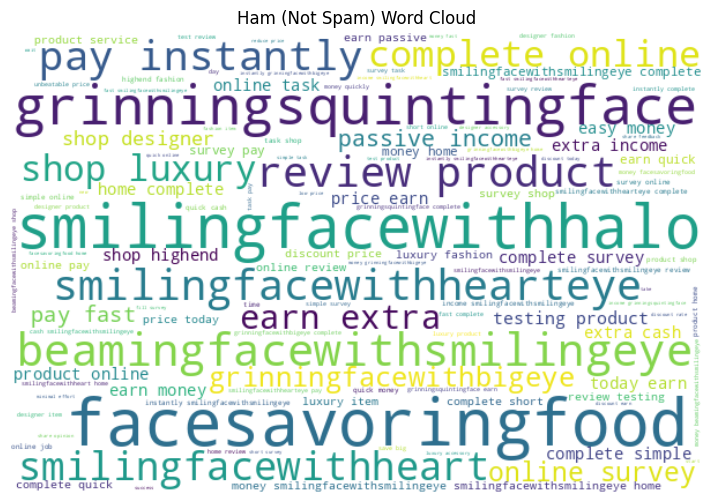

In [10]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate word cloud for ham messages
ham_words = " ".join(df[df["label"] == 0]["clean_text"])
ham_wordcloud = WordCloud(width=600, height=400, background_color="white").generate(ham_words)

# Plot the word cloud
fig, ax = plt.subplots(figsize=(12, 6))  # No need for (1,1), just a single axis

ax.imshow(ham_wordcloud, interpolation="bilinear")
ax.set_title("Ham (Not Spam) Word Cloud")
ax.axis("off")  # Hide axes

plt.show()


<ipython-input-11-f7d96715a927>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=spam_bigrams["Bigram"], x=spam_bigrams["Count"], palette="Reds_r")


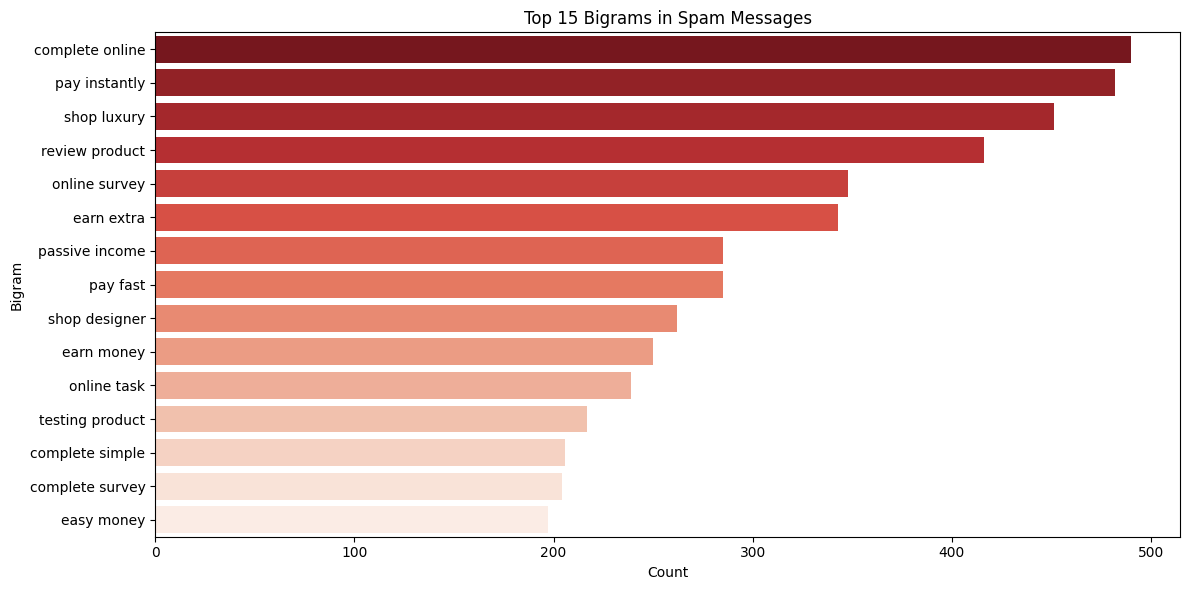

In [11]:
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

def get_top_bigrams(texts, top_n=15):
    vectorizer = CountVectorizer(ngram_range=(2,2), stop_words="english")
    X = vectorizer.fit_transform(texts)
    bigram_counts = X.toarray().sum(axis=0)
    bigram_names = vectorizer.get_feature_names_out()

    return pd.DataFrame(sorted(zip(bigram_names, bigram_counts), key=lambda x: x[1], reverse=True)[:top_n],
                        columns=["Bigram", "Count"])

# Get most common bigrams
spam_bigrams = get_top_bigrams(df[df["label"] == 1]["clean_text"])
ham_bigrams = get_top_bigrams(df[df["label"] == 0]["clean_text"])

# Plot side by side
fig, ax = plt.subplots(figsize=(12, 6))

sns.barplot(y=spam_bigrams["Bigram"], x=spam_bigrams["Count"], palette="Reds_r")
ax.set_title("Top 15 Bigrams in Spam Messages")
ax.set_xlabel("Count")


plt.tight_layout()
plt.show()


<ipython-input-12-18e82cdc6603>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=ham_bigrams["Bigram"], x=ham_bigrams["Count"], palette="Blues_r")


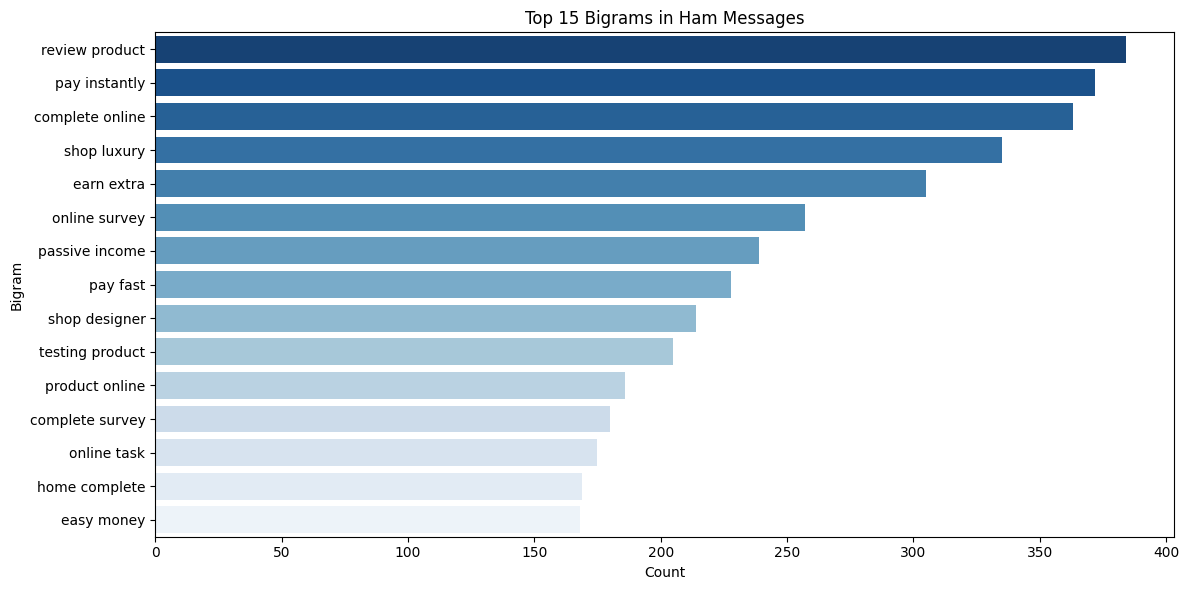

In [12]:
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

def get_top_bigrams(texts, top_n=15):
    vectorizer = CountVectorizer(ngram_range=(2,2), stop_words="english")
    X = vectorizer.fit_transform(texts)
    bigram_counts = X.toarray().sum(axis=0)
    bigram_names = vectorizer.get_feature_names_out()

    return pd.DataFrame(sorted(zip(bigram_names, bigram_counts), key=lambda x: x[1], reverse=True)[:top_n],
                        columns=["Bigram", "Count"])

# Get most common bigrams
spam_bigrams = get_top_bigrams(df[df["label"] == 1]["clean_text"])
ham_bigrams = get_top_bigrams(df[df["label"] == 0]["clean_text"])

# Plot side by side
fig, ax = plt.subplots(figsize=(12, 6))



sns.barplot(y=ham_bigrams["Bigram"], x=ham_bigrams["Count"], palette="Blues_r")
ax.set_title("Top 15 Bigrams in Ham Messages")
ax.set_xlabel("Count")

plt.tight_layout()
plt.show()


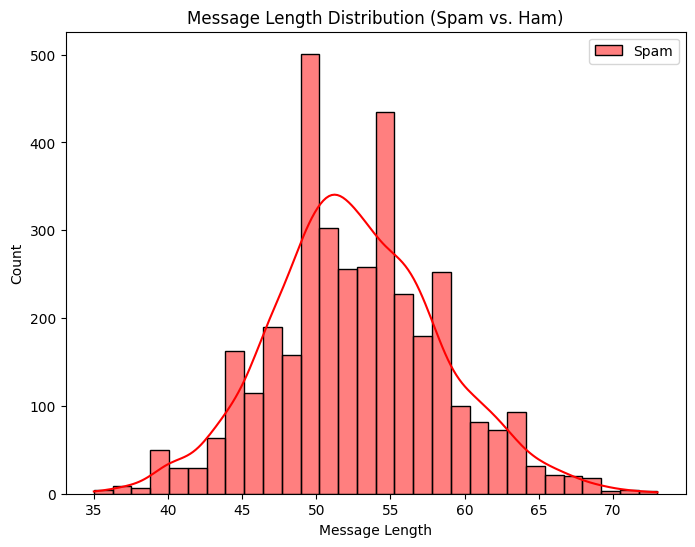

In [13]:
df["text_length"] = df["text"].apply(len)

plt.figure(figsize=(8, 6))
sns.histplot(df[df["label"] == 1]["text_length"], color="red", label="Spam", kde=True, bins=30)
plt.xlabel("Message Length")
plt.ylabel("Count")
plt.title("Message Length Distribution (Spam vs. Ham)")
plt.legend()
plt.show()


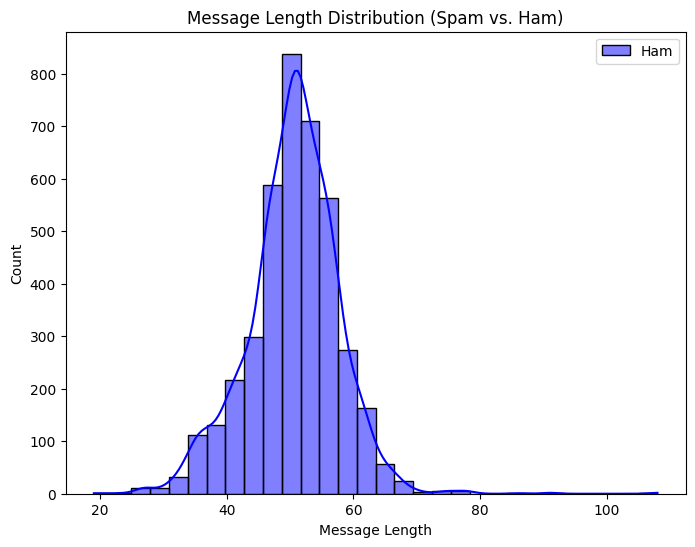

In [14]:
df["text_length"] = df["text"].apply(len)

plt.figure(figsize=(8, 6))

sns.histplot(df[df["label"] == 0]["text_length"], color="blue", label="Ham", kde=True, bins=30)
plt.xlabel("Message Length")
plt.ylabel("Count")
plt.title("Message Length Distribution (Spam vs. Ham)")
plt.legend()
plt.show()


<Figure size 800x600 with 0 Axes>

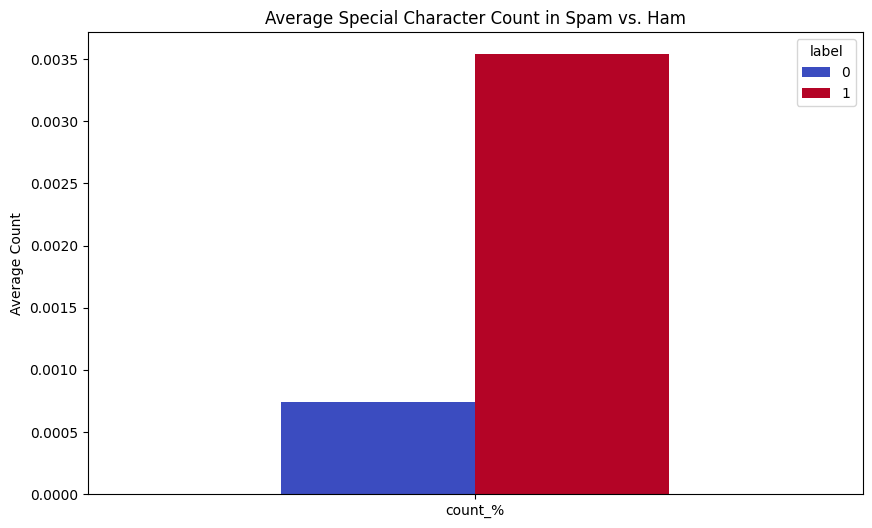

In [15]:
import string

special_chars = ["%"]
for char in special_chars:
    df[f"count_{char}"] = df["text"].apply(lambda x: x.count(char))

plt.figure(figsize=(8, 6))
df.groupby("label")[["count_%"]].mean().T.plot(kind="bar", figsize=(10, 6), colormap="coolwarm")
plt.title("Average Special Character Count in Spam vs. Ham")
plt.ylabel("Average Count")
plt.xticks(rotation=0)
plt.show()

<Figure size 800x600 with 0 Axes>

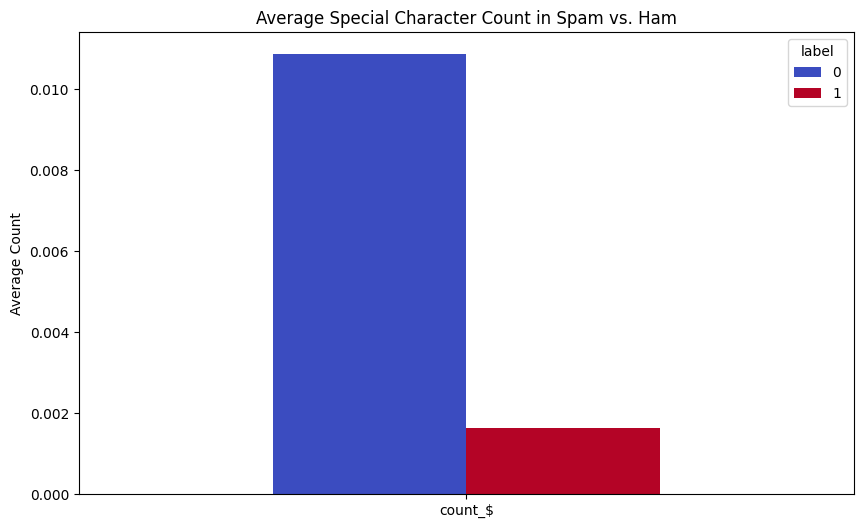

In [16]:
import string

special_chars = ["$"]
for char in special_chars:
    df[f"count_{char}"] = df["text"].apply(lambda x: x.count(char))

plt.figure(figsize=(8, 6))
df.groupby("label")[["count_$"]].mean().T.plot(kind="bar", figsize=(10, 6), colormap="coolwarm")
plt.title("Average Special Character Count in Spam vs. Ham")
plt.ylabel("Average Count")
plt.xticks(rotation=0)
plt.show()


<Figure size 800x600 with 0 Axes>

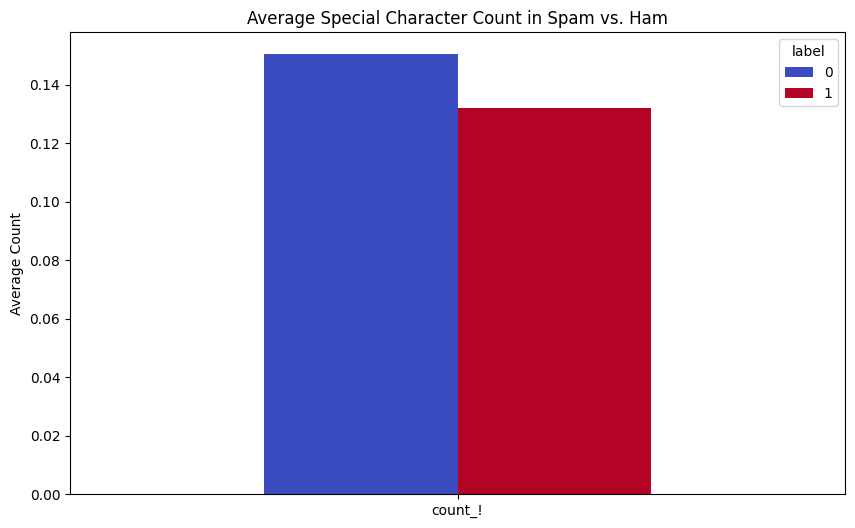

In [17]:
import string

special_chars = ["!"]
for char in special_chars:
    df[f"count_{char}"] = df["text"].apply(lambda x: x.count(char))

plt.figure(figsize=(8, 6))
df.groupby("label")[["count_!"]].mean().T.plot(kind="bar", figsize=(10, 6), colormap="coolwarm")
plt.title("Average Special Character Count in Spam vs. Ham")
plt.ylabel("Average Count")
plt.xticks(rotation=0)
plt.show()

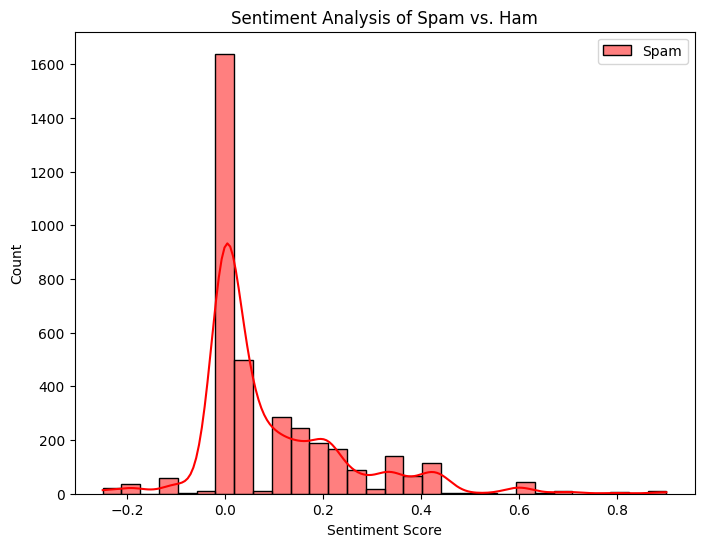

In [18]:
from textblob import TextBlob

df["sentiment"] = df["clean_text"].apply(lambda x: TextBlob(x).sentiment.polarity)

plt.figure(figsize=(8,6))
sns.histplot(df[df["label"] == 1]["sentiment"], color="red", label="Spam", kde=True, bins=30)
plt.xlabel("Sentiment Score")
plt.ylabel("Count")
plt.title("Sentiment Analysis of Spam vs. Ham")
plt.legend()
plt.show()


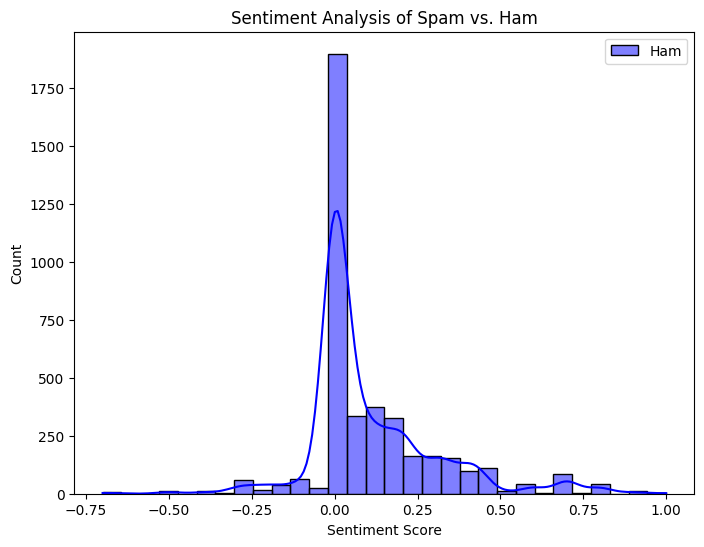

In [19]:
from textblob import TextBlob

df["sentiment"] = df["clean_text"].apply(lambda x: TextBlob(x).sentiment.polarity)

plt.figure(figsize=(8,6))
sns.histplot(df[df["label"] == 0]["sentiment"], color="blue", label="Ham", kde=True, bins=30)
plt.xlabel("Sentiment Score")
plt.ylabel("Count")
plt.title("Sentiment Analysis of Spam vs. Ham")
plt.legend()
plt.show()


In [20]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(df["clean_text"], df["label"], test_size=0.2, random_state=42)


In [21]:
# Convert Text to Numerical Representation using TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


In [22]:
# Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train_tfidf, y_train)
y_pred_rf = rf_model.predict(X_test_tfidf)

# Evaluate Random Forest
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.9954692556634305

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       786
           1       1.00      0.99      1.00       759

    accuracy                           1.00      1545
   macro avg       1.00      1.00      1.00      1545
weighted avg       1.00      1.00      1.00      1545



In [23]:
# Train Naïve Bayes Classifier
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
y_pred_nb = nb_model.predict(X_test_tfidf)

# Evaluate Naïve Bayes
print("Naïve Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_nb))


Naïve Bayes Accuracy: 0.9941747572815534

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       786
           1       1.00      0.99      0.99       759

    accuracy                           0.99      1545
   macro avg       0.99      0.99      0.99      1545
weighted avg       0.99      0.99      0.99      1545



In [24]:
# Train Logistic Regression
lr_model = LogisticRegression(max_iter=500)
lr_model.fit(X_train_tfidf, y_train)
y_pred_lr = lr_model.predict(X_test_tfidf)

# Evaluate Logistic Regression
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))


Logistic Regression Accuracy: 0.9941747572815534

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       786
           1       1.00      0.99      0.99       759

    accuracy                           0.99      1545
   macro avg       0.99      0.99      0.99      1545
weighted avg       0.99      0.99      0.99      1545



In [25]:
# Train KNN Classifier
knn_model = KNeighborsClassifier(n_neighbors=50)
knn_model.fit(X_train_tfidf, y_train)
y_pred_knn = knn_model.predict(X_test_tfidf)

# Evaluate KNN
print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))
print("\nClassification Report:\n", classification_report(y_test, y_pred_knn))


KNN Accuracy: 0.945631067961165

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.92      0.95       786
           1       0.93      0.97      0.95       759

    accuracy                           0.95      1545
   macro avg       0.95      0.95      0.95      1545
weighted avg       0.95      0.95      0.95      1545



In [26]:
# Train XGBoost Classifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_tfidf, y_train)
y_pred_xgb = xgb_model.predict(X_test_tfidf)

# Evaluate XGBoost
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:41:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.996116504854369

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       786
           1       1.00      0.99      1.00       759

    accuracy                           1.00      1545
   macro avg       1.00      1.00      1.00      1545
weighted avg       1.00      1.00      1.00      1545



In [27]:
from sklearn.svm import SVC

# Train SVM Classifier
svm_model = SVC(kernel='linear', probability=True, random_state=42)
svm_model.fit(X_train_tfidf, y_train)
y_pred_svm = svm_model.predict(X_test_tfidf)

# Evaluate SVM
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm))


SVM Accuracy: 0.998705501618123

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       786
           1       1.00      1.00      1.00       759

    accuracy                           1.00      1545
   macro avg       1.00      1.00      1.00      1545
weighted avg       1.00      1.00      1.00      1545



In [28]:
# Store results in a dictionary
results = {
    "Random Forest": accuracy_score(y_test, y_pred_rf),
    "Naïve Bayes": accuracy_score(y_test, y_pred_nb),
    "Logistic Regression": accuracy_score(y_test, y_pred_lr),
    "KNN": accuracy_score(y_test, y_pred_knn),
    "XGBoost": accuracy_score(y_test, y_pred_xgb),
    "SVM": accuracy_score(y_test, y_pred_svm),
}

# Print Accuracy Comparison
for model, acc in results.items():
    print(f"{model}: {acc:.4f}")


Random Forest: 0.9955
Naïve Bayes: 0.9942
Logistic Regression: 0.9942
KNN: 0.9456
XGBoost: 0.9961
SVM: 0.9987


In [29]:
# Find the model with the highest accuracy
best_model_name = max(results, key=results.get)
best_accuracy = results[best_model_name]

# Print the best model and its accuracy
print(f"\n Best Model: {best_model_name}")
print(f" Accuracy: {best_accuracy:.4f}")



 Best Model: SVM
 Accuracy: 0.9987


In [30]:
from sklearn.ensemble import VotingClassifier
import numpy as np

# Sort models by accuracy and get the top 2
top_2_models = sorted(results.items(), key=lambda x: x[1], reverse=True)[:2]

# Extract model names
top_model_1_name, top_model_2_name = top_2_models[0][0], top_2_models[1][0]
print(f" Top 2 Models for Ensemble: {top_model_1_name} & {top_model_2_name}")

# Define the selected models
model_mapping = {
    "Random Forest": rf_model,
    "Naïve Bayes": nb_model,
    "Logistic Regression": lr_model,
    "KNN": knn_model,
    "XGBoost": xgb_model,
    "SVM": svm_model,
}

# Get the top 2 model instances
model_1, model_2 = model_mapping[top_model_1_name], model_mapping[top_model_2_name]


# Final ensemble function
class EnsembleModel:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2

    def predict_proba(self, X):
        # Get probabilities from both models
        prob_1 = self.model_1.predict_proba(X)[:, 1]  # Probability for class 1
        prob_2 = self.model_2.predict_proba(X)[:, 1]

        # Soft voting (average probabilities)
        avg_prob = (prob_1 + prob_2) / 2
        return np.vstack([1 - avg_prob, avg_prob]).T  # Convert back to 2-column format

    def predict(self, X):
        # Convert probabilities to binary predictions
        return np.where(self.predict_proba(X)[:, 1] > 0.5, 1, 0)

# Create the ensemble model
final_model = EnsembleModel(svm_model, xgb_model)

print(" Ensemble Model (SVM + XGBoost) is ready!")

 Top 2 Models for Ensemble: SVM & XGBoost
 Ensemble Model (SVM + XGBoost) is ready!


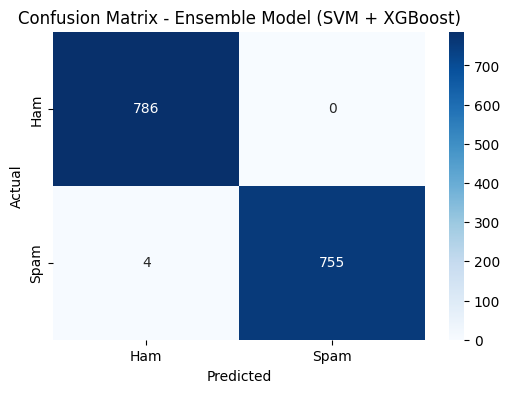

In [31]:
from sklearn.metrics import confusion_matrix

# Get predictions from ensemble model
y_pred_ensemble = final_model.predict(X_test_tfidf)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_ensemble)

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Ensemble Model (SVM + XGBoost)")
plt.show()


In [32]:
import pickle

model_path = "/content/drive/MyDrive/Python/sandhiya/Text_emoji_label/ensemble_model.pkl"

# Save the trained ensemble model
with open(model_path, "wb") as model_file:
    pickle.dump(final_model, model_file)

print(f" Model saved successfully at: {model_path}")


 Model saved successfully at: /content/drive/MyDrive/Python/sandhiya/Text_emoji_label/ensemble_model.pkl


In [33]:
import pickle

# Save the trained TF-IDF vectorizer
vectorizer_path = "/content/drive/MyDrive/Python/sandhiya/Text_emoji_label/tfidf_vectorizer.pkl"
with open(vectorizer_path, "wb") as vec_file:
    pickle.dump(vectorizer, vec_file)

print(f" TF-IDF Vectorizer saved successfully at: {vectorizer_path}")


 TF-IDF Vectorizer saved successfully at: /content/drive/MyDrive/Python/sandhiya/Text_emoji_label/tfidf_vectorizer.pkl


In [34]:
# Function to predict user input
def predict_user_input(final_model, vectorizer):
    while True:
        user_text = input("\nEnter a message to classify (or type 'exit' to quit): ")
        if user_text.lower() == "exit":
            print("Goodbye! ")
            break

        # Clean the input text
        cleaned_text = clean_text_spacy(user_text)

        # Convert to TF-IDF
        text_tfidf = vectorizer.transform([cleaned_text])

        # Predict
        prediction = final_model.predict(text_tfidf)[0]

        # Convert numeric prediction to label
        label = "Spam" if prediction == 1 else "Ham"

        print(f"Prediction: {label} ")

# Call function with best model and vectorizer
predict_user_input(final_model, vectorizer)



Enter a message to classify (or type 'exit' to quit): 
Prediction: Ham 

Enter a message to classify (or type 'exit' to quit): 
Prediction: Ham 

Enter a message to classify (or type 'exit' to quit): exit
Goodbye! 


In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Store the model performance metrics
metrics = {
    "Random Forest": {
        "Accuracy": accuracy_score(y_test, y_pred_rf),
        "Precision": classification_report(y_test, y_pred_rf, output_dict=True)['1']['precision'],
        "Recall": classification_report(y_test, y_pred_rf, output_dict=True)['1']['recall'],
        "F1-Score": classification_report(y_test, y_pred_rf, output_dict=True)['1']['f1-score'],
    },
    "Naïve Bayes": {
        "Accuracy": accuracy_score(y_test, y_pred_nb),
        "Precision": classification_report(y_test, y_pred_nb, output_dict=True)['1']['precision'],
        "Recall": classification_report(y_test, y_pred_nb, output_dict=True)['1']['recall'],
        "F1-Score": classification_report(y_test, y_pred_nb, output_dict=True)['1']['f1-score'],
    },
    "Logistic Regression": {
        "Accuracy": accuracy_score(y_test, y_pred_lr),
        "Precision": classification_report(y_test, y_pred_lr, output_dict=True)['1']['precision'],
        "Recall": classification_report(y_test, y_pred_lr, output_dict=True)['1']['recall'],
        "F1-Score": classification_report(y_test, y_pred_lr, output_dict=True)['1']['f1-score'],
    },
    "KNN": {
        "Accuracy": accuracy_score(y_test, y_pred_knn),
        "Precision": classification_report(y_test, y_pred_knn, output_dict=True)['1']['precision'],
        "Recall": classification_report(y_test, y_pred_knn, output_dict=True)['1']['recall'],
        "F1-Score": classification_report(y_test, y_pred_knn, output_dict=True)['1']['f1-score'],
    },
    "XGBoost": {
        "Accuracy": accuracy_score(y_test, y_pred_xgb),
        "Precision": classification_report(y_test, y_pred_xgb, output_dict=True)['1']['precision'],
        "Recall": classification_report(y_test, y_pred_xgb, output_dict=True)['1']['recall'],
        "F1-Score": classification_report(y_test, y_pred_xgb, output_dict=True)['1']['f1-score'],
    },
    "SVM": {
        "Accuracy": accuracy_score(y_test, y_pred_svm),
        "Precision": classification_report(y_test, y_pred_svm, output_dict=True)['1']['precision'],
        "Recall": classification_report(y_test, y_pred_svm, output_dict=True)['1']['recall'],
        "F1-Score": classification_report(y_test, y_pred_svm, output_dict=True)['1']['f1-score'],
    },
}

# Convert to DataFrame for easier plotting
df_metrics = pd.DataFrame(metrics).T



<ipython-input-43-859a14210f15>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=df_metrics.index, y=df_metrics["Accuracy"], palette="Blues_d")


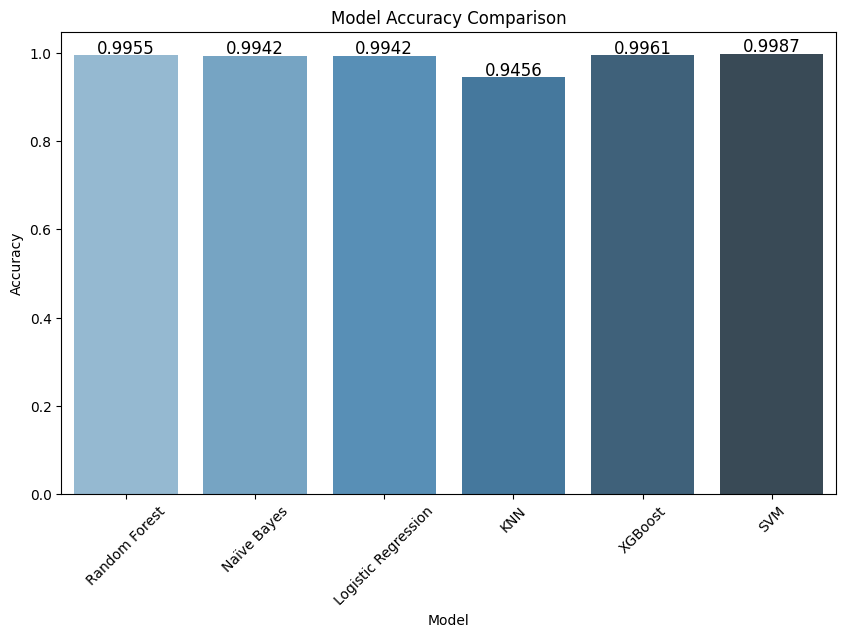

In [43]:
# Plot Accuracy Comparison with values on top of bars
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=df_metrics.index, y=df_metrics["Accuracy"], palette="Blues_d")
plt.title("Model Accuracy Comparison")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)

# Add accuracy values on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.4f}',  # Format the accuracy to 4 decimal places
                (p.get_x() + p.get_width() / 2., p.get_height()),  # Position it at the top of the bar
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

plt.show()


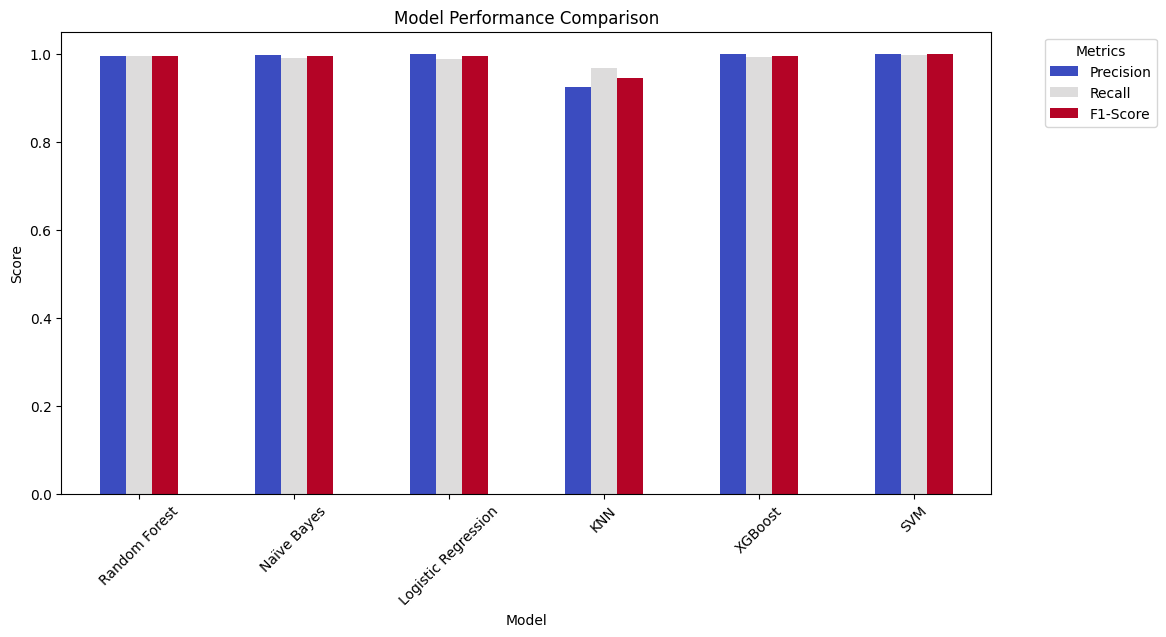

In [49]:
# Plot Precision, Recall, and F1-Score using a bar chart
df_metrics[["Precision", "Recall", "F1-Score"]].plot(kind="bar", stacked=False, figsize=(12, 6), colormap="coolwarm")
plt.title("Model Performance Comparison")
plt.xlabel("Model")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(title="Metrics", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
